In [10]:
import os
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import average_precision_score

import statsmodels.api as sm

# It will be used when doing the jigsaw puzzle
try:
    from PIL import Image
    PIL_OK = True
except Exception:
    PIL_OK = False

warnings.filterwarnings("ignore")

First, global parameters such as the data file path, target variable, environmental factors, and outbreak threshold were defined. 

Subsequently, a set of general functions was provided for parsing various date formats, standardizing site column names, cleaning numerical data, and formatting output file names.

In [11]:

# Global constants
CSV_PATH = Path("Hurdle COTS.csv")
TARGET_COL = "MEAN_COTS_PER_TOW"
ENV_VARS = ["eta", "salt", "temp", "DIN", "DIP", "Dust", "PH", "Oxygen", "Chl", "current_speed", "wind_speed"]
OUTBREAK_THRESH = 0.22
N_FUTURE = 5  # number of future years to forecast
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Helper functions
def parse_year_date(col: pd.Series) -> pd.Series:
    """
    Parse year-only date column (YYYY) and align to year-end.
    """
    return pd.to_datetime(col.astype(str).str.strip(), format="%Y", errors="coerce") + pd.offsets.YearEnd(0)


def safe_numeric(df: pd.DataFrame, cols) -> pd.DataFrame:
    """
    Convert selected columns to numeric (invalid entries become NaN).
    """
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def titlecase_file_stub(name: str) -> str:
    """
    Clean up strings for safe file naming (remove spaces/special chars).
    """
    return re.sub(r'[^A-Za-z0-9]+', '_', str(name)).strip('_')


This code is used to read the original data file and check if the date column is correct 
(because in previous attempts, I opened the CSV file using Excel, which caused the date column to be automatically recognized and changed).

Firstly, it reads the data from `Hurdle COTS.csv` and confirms the existence of a column named `date`.

Then, it attempts to convert the date strings into a standard date format and counts the number of successful and failed rows to check the data quality.
If there are unparseable dates, it outputs the first 20 examples to help locate the problem; if everything is normal, it displays a success message.

Finally, the code calls the unified date parsing function, converts all dates to a standard format and aligns them to the end of the year, and saves them as a new file.

In [12]:

# 1) Read source file & check/repair date column
print("=== Step 1: Reading source file and checking date column ===")
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Cannot find data file: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

# Check if date column exists
if "date" not in df.columns:
    raise KeyError(f"No column named 'date' found. Existing columns: {df.columns.tolist()}")

df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")

invalid_rows = df[df["date_parsed"].isna()]["date"]
print("—— Date column check results ——")
print(f"Total rows: {len(df)}")
print(f"Successfully parsed dates: {(~df['date_parsed'].isna()).sum()}")
print(f"Failed or missing dates: {df['date_parsed'].isna().sum()}")

if not invalid_rows.empty:
    print("\n Some rows have invalid or unrecognized date formats (first 20 shown):")
    print(invalid_rows.head(20))
else:
    print("\n All date formats are valid.")

print("\nFirst 10 parsed dates:")
print(df["date_parsed"].head(10))

# Replace with unified mixed-format parser
print("\n=== Step 2: Parsing date column using unified format ===")
df["date"] = pd.to_datetime(df["date"].astype(str).str.strip(), format="%Y", errors="coerce") + pd.offsets.YearEnd(0)
df = df.dropna(subset=["date"]).copy()
print("First 10 standardized (year-end aligned) dates:")
print(df["date"].head(10))

# Save repaired version
df.to_csv("Hurdle_COTS_date_fixed.csv", index=False, encoding="utf-8")
print("\n Date parsing completed. Saved as: Hurdle_COTS_date_fixed.csv")


=== Step 1: Reading source file and checking date column ===
—— Date column check results ——
Total rows: 48
Successfully parsed dates: 48
Failed or missing dates: 0

 All date formats are valid.

First 10 parsed dates:
0   1970-01-01 00:00:00.000002011
1   1970-01-01 00:00:00.000002012
2   1970-01-01 00:00:00.000002013
3   1970-01-01 00:00:00.000002014
4   1970-01-01 00:00:00.000002015
5   1970-01-01 00:00:00.000002016
6   1970-01-01 00:00:00.000002017
7   1970-01-01 00:00:00.000002018
8   1970-01-01 00:00:00.000002011
9   1970-01-01 00:00:00.000002012
Name: date_parsed, dtype: datetime64[ns]

=== Step 2: Parsing date column using unified format ===
First 10 standardized (year-end aligned) dates:
0   2011-12-31
1   2012-12-31
2   2013-12-31
3   2014-12-31
4   2015-12-31
5   2016-12-31
6   2017-12-31
7   2018-12-31
8   2011-12-31
9   2012-12-31
Name: date, dtype: datetime64[ns]

 Date parsing completed. Saved as: Hurdle_COTS_date_fixed.csv


The following code is used to summarize the data of the Crown-of-Thorns Starfish (COTS) by year and establish an overall annual outbreak probability model. 

1. Data preprocessing and annual aggregation:
Group the original data by year, calculate the average values of the target variable (starfish density) and environmental factors for each year, and fill in the missing data using interpolation methods. 

2. Feature and Label Construction:
Standardize the annual average data to generate the feature matrix `X` for modeling and the outbreak label `y` (considering an outbreak when `MEAN_COTS_PER_TOW` is greater than the threshold of 0.22). 

3. Logistic Regression Model:
If the sample size is sufficient, the "Leave-One-Out" cross-validation method is employed to estimate the model performance, and the average PR-AUC (Precision-Recall Area Under Curve) is output; if the sample size is too small, the full sample is directly used for fitting. 

4. Visualized Results
Create a graph showing the changes in predicted outbreak probabilities each year, illustrating the annual outbreak trends identified by the model.


=== Step 3: Annual aggregation (overall) ===
Number of annual samples: 8
Year range: 2011 → 2018
Mean PR-AUC (leave-one-out) = 0.250


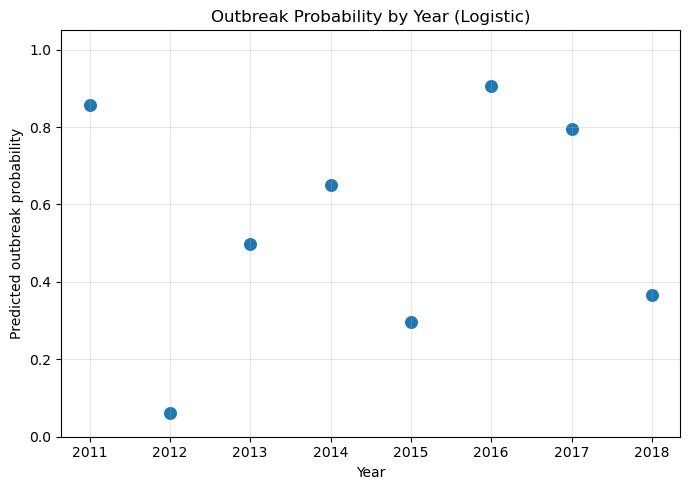

In [13]:
# 2) Annual aggregation & overall Hurdle (Logistic + GLM-NB)
print("\n=== Step 3: Annual aggregation (overall) ===")
df = safe_numeric(df, [TARGET_COL] + ENV_VARS)
df["year"] = df["date"].dt.year

annual = (df.groupby("year")[[TARGET_COL] + ENV_VARS]
            .mean()
            .replace([np.inf, -np.inf], np.nan)
            .interpolate(limit_direction="both"))

print("Number of annual samples:", len(annual))
print("Year range:", annual.index.min(), "→", annual.index.max())
if len(annual) < 2:
    raise ValueError("Fewer than 2 yearly samples; cannot fit the model. Please ensure multiple years of data are available.")

# 3) Prepare features and labels
y_reg = annual[TARGET_COL].copy()
y_cls = (y_reg > OUTBREAK_THRESH).astype(int)
X = annual[ENV_VARS].copy().ffill().bfill()

scaler_all = StandardScaler()
X_scaled = pd.DataFrame(scaler_all.fit_transform(X), index=X.index, columns=X.columns)

# 4) Logistic
years = X_scaled.index.values
if len(X_scaled) >= 3:
    loo = LeaveOneOut()
    pred_prob = pd.Series(index=X_scaled.index, dtype=float)
    scores = []
    for train, test in loo.split(X_scaled):
        Xtr, Xte = X_scaled.iloc[train], X_scaled.iloc[test]
        ytr, yte = y_cls.iloc[train], y_cls.iloc[test]
        clf = LogisticRegression(class_weight="balanced", max_iter=500)
        clf.fit(Xtr, ytr)
        p = clf.predict_proba(Xte)[:, 1][0]
        pred_prob.iloc[test] = p
        scores.append(average_precision_score(yte, [p]))
    mean_ap = float(np.mean(scores))
    print(f"Mean PR-AUC (leave-one-out) = {mean_ap:.3f}")
else:
    print(f"Only {len(X_scaled)} samples; skip cross-validation and fit on all data.")
    clf = LogisticRegression(class_weight="balanced", max_iter=500)
    clf.fit(X_scaled, y_cls)
    pred_prob = pd.Series(clf.predict_proba(X_scaled)[:, 1], index=X_scaled.index)
    mean_ap = average_precision_score(y_cls, pred_prob)

plt.figure(figsize=(7, 5))
plt.scatter(years, pred_prob.values, s=70)
plt.xticks(years)
plt.ylim(0, 1.05)
plt.ylabel("Predicted outbreak probability")
plt.xlabel("Year")
plt.title("Outbreak Probability by Year (Logistic)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Annual_Logistic_Probability.png", dpi=300)
plt.show()


The following code is used to calculate and visualize the intensity of the annual outbreak of the starry starfish and the comprehensive risk index.

Firstly, it uses negative binomial regression (GLM-NB) to fit the outbreak samples and predict the intensity of the outbreak each year; if there are too few outbreak samples, the average value is used instead.

Then, the outbreak probability from the previous Logistic model is multiplied by the predicted intensity to obtain the annual risk index (risk = p × intensity).

The code then plots three graphs: the change in observations, outbreak probability, predicted intensity and comprehensive risk, and outputs the model summary, PR-AUC and prediction result table, which are used to evaluate the annual outbreak risk trend.


 Only 2 outbreak samples found — GLM-NB may be unstable; using mean substitution instead.

=== Model Summary ===
Number of annual samples: 8, Outbreak ratio: 25.0%
PR-AUC: 0.250

First few prediction results:
      observed  p_outbreak  intensity_hat      risk
year                                               
2011  0.002333    0.856490       0.013361  0.011444
2012  0.000000    0.060576       0.013361  0.000809
2013  0.031667    0.497929       0.013361  0.006653
2014  0.008167    0.649703       0.013361  0.008681
2015  0.014167    0.297236       0.013361  0.003971


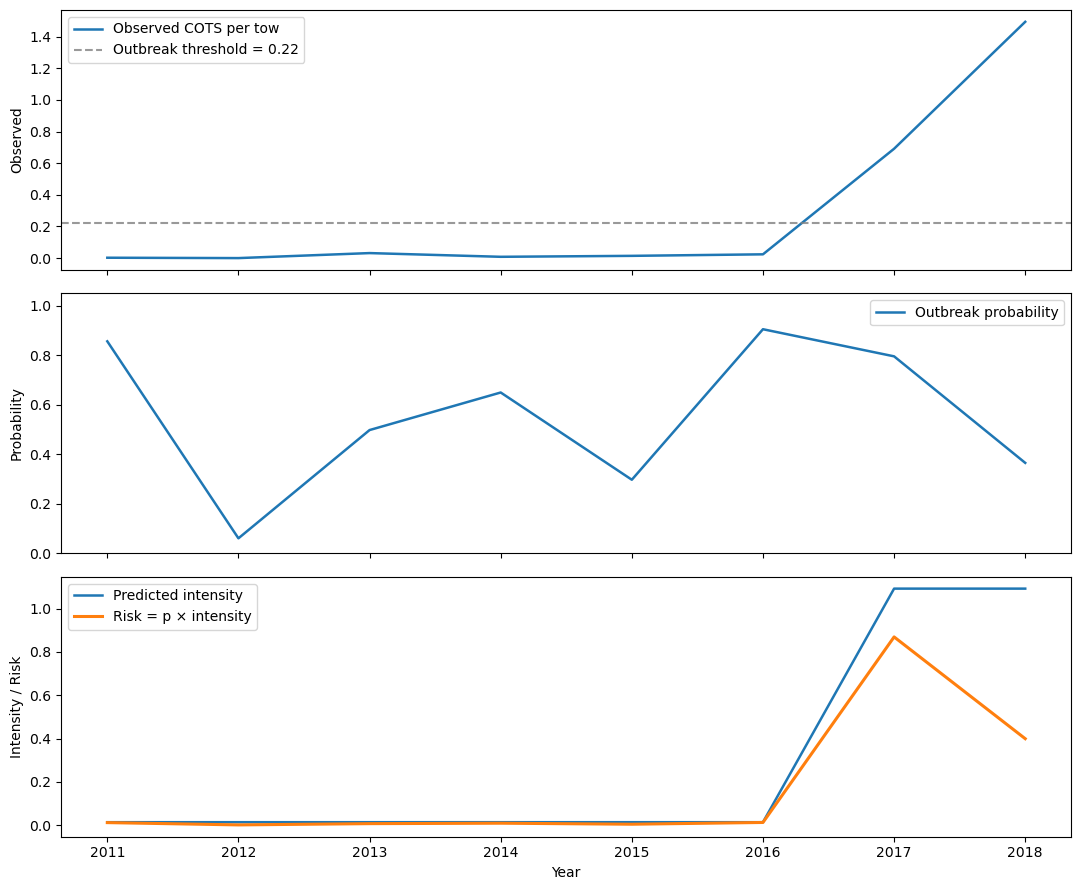

In [14]:
# 5) GLM-NB (Intensity)
pos_mask = y_reg > OUTBREAK_THRESH
X_pos = X_scaled.loc[pos_mask]
y_pos = y_reg.loc[pos_mask]

if len(X_pos) >= 3:
    X_pos_sm = sm.add_constant(X_pos, has_constant="add")
    nb_model = sm.GLM(y_pos, X_pos_sm, family=sm.families.NegativeBinomial())
    nb_res = nb_model.fit()
    print("\n=== GLM Negative Binomial Regression Summary ===")
    print(nb_res.summary())
    X_all_sm = sm.add_constant(X_scaled, has_constant="add")
    y_hat_intensity = pd.Series(nb_res.predict(X_all_sm), index=X_scaled.index, name="intensity_hat")
else:
    print(f"\n Only {len(X_pos)} outbreak samples found — GLM-NB may be unstable; using mean substitution instead.")
    y_hat_intensity = pd.Series(np.nan, index=X_scaled.index, name="intensity_hat")
    if len(y_pos) > 0:
        y_hat_intensity.loc[pos_mask] = y_pos.mean()
    y_hat_intensity.loc[~pos_mask] = y_reg.loc[~pos_mask].clip(upper=OUTBREAK_THRESH).mean()

# 6) Risk index
risk = (pred_prob * y_hat_intensity).rename("risk")

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)
axes[0].plot(y_reg.index, y_reg.values, label="Observed COTS per tow", lw=1.8)
axes[0].axhline(OUTBREAK_THRESH, ls="--", color="gray", alpha=0.8,
                label=f"Outbreak threshold = {OUTBREAK_THRESH}")
axes[0].legend(); axes[0].set_ylabel("Observed")

axes[1].plot(pred_prob.index, pred_prob.values, label="Outbreak probability", lw=1.8)
axes[1].set_ylim(0, 1.05)
axes[1].legend(); axes[1].set_ylabel("Probability")

axes[2].plot(y_hat_intensity.index, y_hat_intensity.values, label="Predicted intensity", lw=1.8)
axes[2].plot(risk.index, risk.values, label="Risk = p × intensity", lw=2.2)
axes[2].set_ylabel("Intensity / Risk"); axes[2].set_xlabel("Year")
axes[2].legend()

plt.tight_layout()
plt.savefig("Annual_Hurdle_Risk.png", dpi=300)
plt.show()

print("\n=== Model Summary ===")
print(f"Number of annual samples: {len(annual)}, Outbreak ratio: {y_cls.mean():.1%}")
print(f"PR-AUC: {mean_ap:.3f}")
out_tbl = pd.concat([y_reg.rename("observed"),
                     pred_prob.rename("p_outbreak"),
                     y_hat_intensity,
                     risk], axis=1)
print("\nFirst few prediction results:")
print(out_tbl.head())


The following code is used to compare the annual outbreak probabilities of the starry starfish at different sites.

It first calculates the average sea star density and environmental factors for each year based on "site × year", and then estimates the outbreak probability for each year using the Logistic regression model.

Subsequently, all the results from each site are summarized, and the annual outbreak probability curves for each site are plotted separately on the same faceted graph.

Finally, the output image is generated, which is used to visually display the outbreak trends and differences of each site over time.


=== Step 4: Annual outbreak probability by site (faceted view) ===
Saved: Sites_Probability_Facet.png


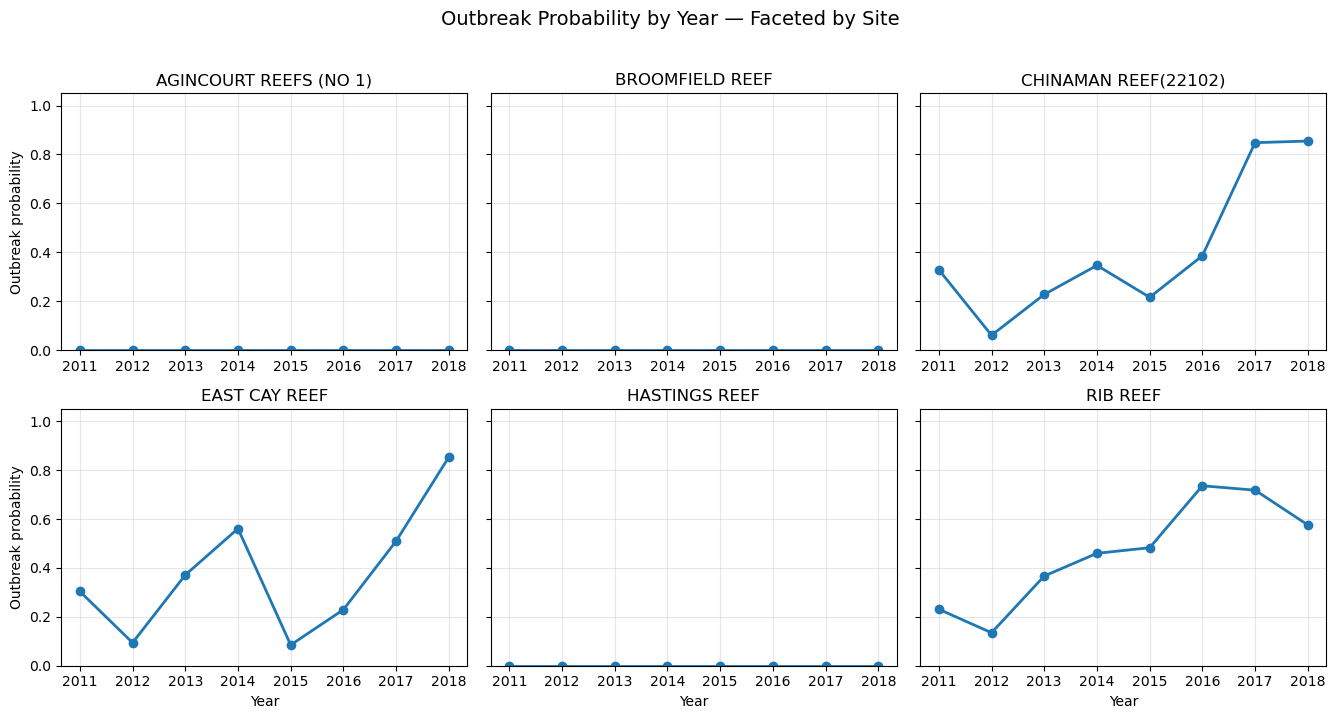

In [17]:
# 3) Faceted plots: yearly outbreak probability by site (Logistic, annual data)
print("\n=== Step 4: Annual outbreak probability by site (faceted view) ===")

df_site = df.copy()
df_site = df_site.rename(columns={"site name": "site"})  # ✅ rename before grouping
df_site = safe_numeric(df_site, [TARGET_COL] + ENV_VARS)

# derive year from 'date' column
df_site["year"] = pd.to_datetime(df_site["date"], errors="coerce").dt.year

annual_site = (df_site.groupby(["site", "year"])[[TARGET_COL] + ENV_VARS]
               .mean()
               .replace([np.inf, -np.inf], np.nan))

sites = sorted(annual_site.index.get_level_values(0).unique().tolist())
if not sites:
    raise ValueError("No site data detected.")

prob_list = []
for site in sites:
    d = annual_site.loc[site].copy()  # index = year
    d = d.interpolate(limit_direction="both")
    if len(d) < 2:
        continue

    y_reg_s = d[TARGET_COL]
    y_cls_s = (y_reg_s > OUTBREAK_THRESH).astype(int)
    X_s = d[ENV_VARS].copy().ffill().bfill()
    Xs = pd.DataFrame(StandardScaler().fit_transform(X_s), index=X_s.index, columns=X_s.columns)

    if y_cls_s.nunique() < 2:
        p = pd.Series(float(y_cls_s.mean()), index=Xs.index, name="p_outbreak")
    else:
        clf = LogisticRegression(class_weight="balanced", max_iter=500, solver="liblinear")
        clf.fit(Xs, y_cls_s)
        p = pd.Series(clf.predict_proba(Xs)[:, 1], index=Xs.index, name="p_outbreak")

    prob_list.append(pd.DataFrame({"site": site, "year": Xs.index, "p_outbreak": p.values}).sort_values("year"))

prob_df = pd.concat(prob_list, ignore_index=True)

# --- Faceted plotting ---
n_sites = prob_df["site"].nunique()
ncols = int(np.ceil(np.sqrt(n_sites)))
nrows = int(np.ceil(n_sites / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 3.5*nrows), sharey=True)
axes = np.array(axes).reshape(nrows, ncols)

for i, site in enumerate(sites):
    r, c = divmod(i, ncols)
    ax = axes[r, c]
    ds = prob_df[prob_df["site"] == site].sort_values("year")
    ax.plot(ds["year"], ds["p_outbreak"], marker="o", lw=2)
    ax.set_title(str(site))
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    if c == 0:
        ax.set_ylabel("Outbreak probability")
    if r == nrows - 1:
        ax.set_xlabel("Year")

# Hide unused subplots
for ax in axes.flatten()[len(sites):]:
    ax.set_visible(False)

plt.suptitle("Outbreak Probability by Year — Faceted by Site", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig("Sites_Probability_Facet.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Sites_Probability_Facet.png")


The function of the following code is to conduct annual outbreak risk prediction for each site.
It utilizes the existing data on sea star density and environmental factors, first fitting a Logistic model (outbreak probability) and a GLM-NB model (outbreak intensity), and then extrapolating based on the linear trend of environmental variables to predict the risk changes in the coming several years.

The specific process includes: 
Fitting stage: Calculate the annual outbreak probability and intensity using historical data. 

Extrapolation stage: Perform a linear trend fitting on the environmental factors to calculate the environmental values for the next several years (N_FUTURE). 

Prediction stage: Using the aforementioned model, estimate the future outbreak probability, intensity, and overall risk (risk = p × intensity). 

Visual output: Generate trend charts for each site showing the observed values, predicted probabilities, intensities, and future risks, and save each chart as an independent file.

In [18]:

# 4) Site-level annual forecasts (trend extrapolation + Hurdle)
print("\n=== Step 5: Site-level annual forecasts (next {} years) ===".format(N_FUTURE))

# Expect: `annual_site` is grouped by ["site name", "date"] where `date` is the year (int)
site_names = sorted(annual_site.index.get_level_values(0).unique().tolist())

for site_name in site_names:
    if site_name not in annual_site.index.get_level_values(0):
        print(f"[Skip] Site not found: {site_name}")
        continue

    d = annual_site.loc[site_name].copy()      # index = date (year as int)
    d = d.replace([np.inf, -np.inf], np.nan).interpolate(limit_direction="both")
    if len(d) < 3:
        print(f"[Skip] {site_name} has too few annual samples ({len(d)})")
        continue

    # 1) Data
    y = d[TARGET_COL]
    y_cls_s = (y > OUTBREAK_THRESH).astype(int)
    X = d[ENV_VARS].copy().ffill().bfill()

    scaler = StandardScaler()
    X_scaled_s = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    # 2) Logistic
    if y_cls_s.nunique() > 1:
        clf = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=500)
        clf.fit(X_scaled_s, y_cls_s)
        p_now = pd.Series(clf.predict_proba(X_scaled_s)[:, 1], index=X.index, name="p_outbreak")
    else:
        p_now = pd.Series(float(y_cls_s.mean()), index=X.index, name="p_outbreak")

    # 3) GLM-NB (intensity)
    pos_mask = y > OUTBREAK_THRESH
    X_pos, y_pos = X_scaled_s.loc[pos_mask], y.loc[pos_mask]
    if len(y_pos) >= 3:
        nb_fit = sm.GLM(y_pos, sm.add_constant(X_pos, has_constant="add"),
                        family=sm.families.NegativeBinomial()).fit()
        y_int_now = pd.Series(nb_fit.predict(sm.add_constant(X_scaled_s, has_constant="add")),
                              index=X.index, name="intensity")
    else:
        y_int_now = pd.Series(np.nan, index=X.index, name="intensity")
        if len(y_pos) > 0:
            y_int_now.loc[pos_mask] = y_pos.mean()
        y_int_now.loc[~pos_mask] = y.loc[~pos_mask].clip(upper=OUTBREAK_THRESH).mean()

    # 4) Linear extrapolation for future environmental variables
    last_date = int(d.index.max())
    future_years = np.arange(last_date + 1, last_date + 1 + N_FUTURE)
    X_future = pd.DataFrame(index=future_years, columns=ENV_VARS, dtype=float)
    for var in ENV_VARS:
        xv = d.index.values.astype(float)
        yv = d[var].astype(float).values
        if np.all(np.isnan(yv)):
            X_future[var] = np.nanmean(yv)
        else:
            good = ~np.isnan(yv)
            coef = np.polyfit(xv[good], yv[good], deg=1)
            X_future[var] = np.polyval(coef, future_years)

    X_future = X_future.ffill().bfill()
    Xf_scaled = pd.DataFrame(scaler.transform(X_future), index=future_years, columns=ENV_VARS)

    # 5) Future probability & intensity
    if y_cls_s.nunique() > 1:
        p_future = pd.Series(clf.predict_proba(Xf_scaled)[:, 1], index=future_years, name="p_outbreak_future")
    else:
        p_future = pd.Series(float(y_cls_s.mean()), index=future_years, name="p_outbreak_future")

    if len(y_pos) >= 3:
        y_int_future = pd.Series(nb_fit.predict(sm.add_constant(Xf_scaled, has_constant="add")),
                                 index=future_years, name="intensity_future")
    else:
        y_int_future = pd.Series(y.mean(), index=future_years, name="intensity_future")

    risk_future = (p_future * y_int_future).rename("risk_future")

    # 6) Plot: observed + (scaled) probability + intensity + future risk
    plt.figure(figsize=(10, 6))
    plt.plot(y.index, y.values, "o-", label="Observed MEAN_COTS_PER_TOW", lw=2)
    plt.axhline(OUTBREAK_THRESH, color="gray", ls="--", label=f"Threshold={OUTBREAK_THRESH}")
    scale_ = max(y.max(), OUTBREAK_THRESH * 2, 1e-6)
    plt.plot(p_now.index, p_now.values * scale_, "--", lw=2, label="Scaled outbreak prob.")
    plt.plot(y_int_now.index, y_int_now.values, "-.", lw=2, label="Intensity fit")
    plt.plot(risk_future.index, risk_future.values, "*-", lw=2, label=f"Predicted future risk (+{N_FUTURE}y)")

    plt.xlabel("Date")   # previously "Year"
    plt.ylabel("COTS / Risk (scaled)")
    plt.title(f"{site_name} — Annual Hurdle Forecast (next {N_FUTURE} years)")
    plt.grid(alpha=0.3); plt.legend()
    fname = f"HurdleForecast_{titlecase_file_stub(site_name)}__.png".replace("__", ".png")
    plt.tight_layout(); plt.savefig(fname, dpi=300); plt.close()
    print(f"Completed forecast for site: {site_name} → {fname}")



=== Step 5: Site-level annual forecasts (next 5 years) ===
Completed forecast for site: AGINCOURT REEFS (NO 1) → HurdleForecast_AGINCOURT_REEFS_NO_1.png.png
Completed forecast for site: BROOMFIELD REEF → HurdleForecast_BROOMFIELD_REEF.png.png
Completed forecast for site: CHINAMAN REEF(22102) → HurdleForecast_CHINAMAN_REEF_22102.png.png
Completed forecast for site: EAST CAY REEF → HurdleForecast_EAST_CAY_REEF.png.png
Completed forecast for site: HASTINGS REEF → HurdleForecast_HASTINGS_REEF.png.png
Completed forecast for site: RIB REEF → HurdleForecast_RIB_REEF.png.png


The following code is used to combine all the annual forecast charts of all sites into a comprehensive overview chart.

It will search for all PNG files starting with 'HurdleForecast_' in the current folder and display them in a grid format automatically.

The program dynamically determines the row and column layout based on the number of images and hides the extra blank sub-charts.

Finally, a summary chart 'HurdleForecast_AllSites.png' is generated and saved, making it convenient to compare the annual forecast results of different sites simultaneously.


=== Step 6: Combine forecast figures for all sites ===
Found 6 forecast figures: ['HurdleForecast_AGINCOURT_REEFS_NO_1.png.png', 'HurdleForecast_BROOMFIELD_REEF.png.png', 'HurdleForecast_CHINAMAN_REEF_22102.png.png', 'HurdleForecast_EAST_CAY_REEF.png.png', 'HurdleForecast_HASTINGS_REEF.png.png', 'HurdleForecast_RIB_REEF.png.png']
Combined summary figure generated: HurdleForecast_AllSites.png


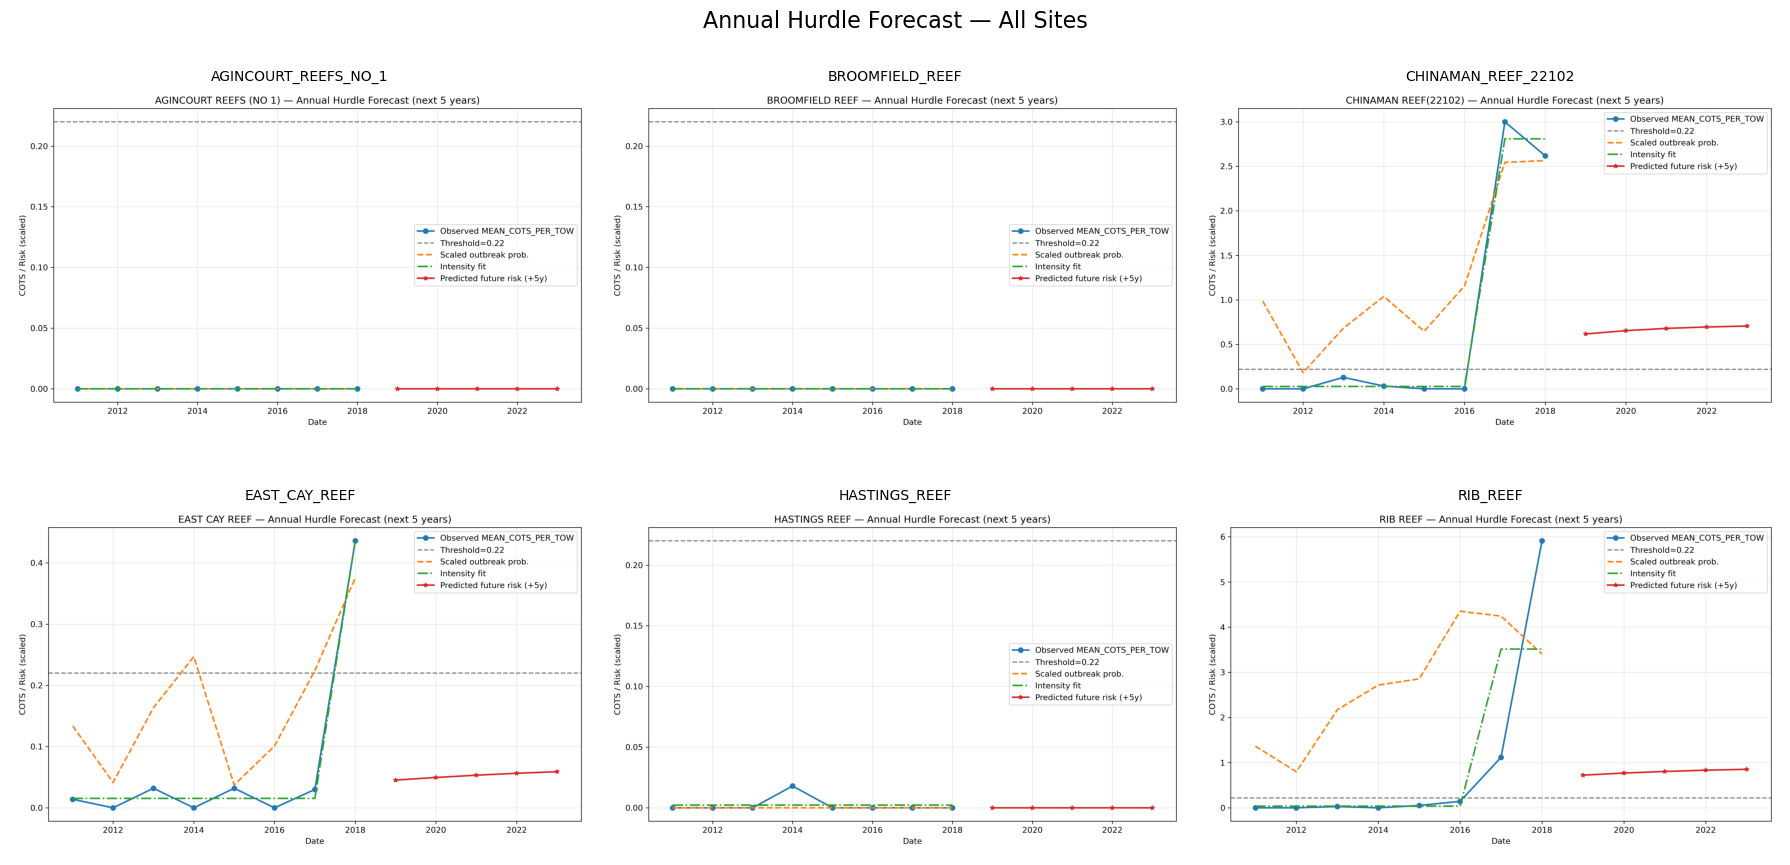

In [19]:

# 5) Combine all site forecast figures
print("\n=== Step 6: Combine forecast figures for all sites ===")

files = sorted([f for f in os.listdir(".") if f.startswith("HurdleForecast_") and f.endswith(".png")])
print(f"Found {len(files)} forecast figures:", files)

if len(files) == 0:
    print("No HurdleForecast_*.png files found — skipping figure combination.")
else:
    ncols = 3
    nrows = int((len(files) + ncols - 1) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))

    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
    last_i = -1

    for i, (ax, file) in enumerate(zip(axes, files)):
        last_i = i
        if PIL_OK:
            img = Image.open(file)
            ax.imshow(img)
        else:
            img = plt.imread(file)
            ax.imshow(img)
        ax.set_title(file.replace("HurdleForecast_", "").replace(".png", ""), fontsize=10)
        ax.axis("off")

    # Hide extra subplots
    for j in range(last_i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Annual Hurdle Forecast — All Sites", fontsize=16, y=0.93)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig("HurdleForecast_AllSites.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Combined summary figure generated: HurdleForecast_AllSites.png")
